In [ ]:
import sys
sys.path.append('../src')
import tools
import pandas as pd 
import numpy as np 
import os
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt
from itertools import combinations


In [97]:
def compute_teamspread(df,color):
    if color: 
        print(f'    Calculating Team Spread: {color.capitalize()}')
    else: 
        print(f'    Calculating Team Spread')

    df = df.copy()
    
    # Extrai os IDs dos jogadores
    ids = sorted({col.split('_')[0] for col in df.columns if col.endswith('_x')})
    
    # Gera todas as combinações possíveis entre pares de jogadores
    pairs = list(combinations(ids, 2))

    # Lista para armazenar as distâncias de cada frame
    all_distances = []

    for id1, id2 in pairs:
        dx = df[f'{id1}_x'] - df[f'{id2}_x']
        dy = df[f'{id1}_y'] - df[f'{id2}_y']
        dist = np.sqrt(dx**2 + dy**2)
        df[f'ts_{id1}_{id2}'] = dist
        all_distances.append(dist)

    # Empilha todas as distâncias calculadas para calcular a média por linha
    all_distances_matrix = np.vstack([d.values for d in all_distances]).T
    df['ts_mean'] = all_distances_matrix.mean(axis=1)

    return df

In [ ]:
def create_teamspread_video(df_b, df_o, sport, save=True):
    if sport:
        print(f'Creating Pairwise Distance Video | {sport.capitalize()}')
    else:
        print('Creating Pairwise Distance Video')

    # Identifica jogadores
    blue_ids = sorted({col.split('_')[0] for col in df_b.columns if col.endswith('_x')})
    orange_ids = sorted({col.split('_')[0] for col in df_o.columns if col.endswith('_x')})

    # Cria campo
    fig, ax = tools.draw_field_court(sport)
    scat_blue = ax.scatter([], [], s=50, color='blue')
    scat_orange = ax.scatter([], [], s=50, color='orange')

    # Linhas de ligação entre jogadores da mesma equipe
    from itertools import combinations
    blue_pairs = list(combinations(blue_ids, 2))
    orange_pairs = list(combinations(orange_ids, 2))

    lines_blue = [ax.plot([], [], 'b:', alpha=0.6)[0] for _ in blue_pairs]
    lines_orange = [ax.plot([], [], color='orange', linestyle=':', alpha=0.6)[0] for _ in orange_pairs]

    # Texto com distâncias médias
    text_blue = ax.text(0.03, 0.945, '', transform=ax.transAxes, fontsize=12, color='black')
    text_orange = ax.text(0.53, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')

    def update(frame):
        # Coords
        blue_coords = [(df_b.loc[frame, f'{pid}_x'], df_b.loc[frame, f'{pid}_y']) for pid in blue_ids]
        orange_coords = [(df_o.loc[frame, f'{pid}_x'], df_o.loc[frame, f'{pid}_y']) for pid in orange_ids]

        scat_blue.set_offsets(blue_coords)
        scat_orange.set_offsets(orange_coords)

        # Linhas azuis
        for i, (id1, id2) in enumerate(blue_pairs):
            x1, y1 = df_b.loc[frame, f'{id1}_x'], df_b.loc[frame, f'{id1}_y']
            x2, y2 = df_b.loc[frame, f'{id2}_x'], df_b.loc[frame, f'{id2}_y']
            lines_blue[i].set_data([x1, x2], [y1, y2])

        # Linhas laranjas
        for i, (id1, id2) in enumerate(orange_pairs):
            x1, y1 = df_o.loc[frame, f'{id1}_x'], df_o.loc[frame, f'{id1}_y']
            x2, y2 = df_o.loc[frame, f'{id2}_x'], df_o.loc[frame, f'{id2}_y']
            lines_orange[i].set_data([x1, x2], [y1, y2])

        # Distância média (pré-calculada em colunas 'ts_mean')
        mean_b = df_b.loc[frame, 'ts_mean'] if 'ts_mean' in df_b.columns else np.nan
        mean_o = df_o.loc[frame, 'ts_mean'] if 'ts_mean' in df_o.columns else np.nan
        text_blue.set_text(f'Blue | Team Spread: {mean_b:.2f} m')
        text_orange.set_text(f'Orange | Team Spread: {mean_o:.2f} m')

        return [scat_blue, scat_orange, text_blue, text_orange] + lines_blue + lines_orange

    min_frames = min(len(df_b), len(df_o))
    anim = FuncAnimation(fig, update, frames=range(0, min_frames, 2), interval=40, blit=True)
    writer = FFMpegWriter(fps=30)

    if save:
        folder_dir = f'../results/teamspread/{sport}/'
        os.makedirs(folder_dir, exist_ok=True)
        print(f'    Saving video: {folder_dir}{sport}.mp4')
        anim.save(f'{folder_dir}{sport}.mp4', writer=writer)

    return anim


In [ ]:
def calculate_teamspread(sport, variable='teamspread', save=True):
    df_b, df_o = tools.load_data(sport)
    df_b = compute_teamspread(df_b, 'blue')
    df_o = compute_teamspread(df_o, 'orange')

    anim = create_teamspread_video(df_b, df_o, sport, save=True)

    if save == True:
        folder_dir = f'../results/{variable}/{sport}/'
        print(f'        Saving data: {folder_dir}{sport}_blue.csv')
        df_b.to_csv(f'{folder_dir}{sport}_blue.csv',index=False)
        print(f'        Saving data: {folder_dir}{sport}_orange.csv')
        df_o.to_csv(f'{folder_dir}{sport}_orange.csv',index=False)
    return df_b, df_o, anim

Loading XY data: Volleyball
    Calculating Team Spread: Blue
    Calculating Team Spread: Orange
Creating Pairwise Distance Video | Volleyball
    Saving video: results/teamspread/volleyball/volleyball.mp4
        Saving data: results/teamspread/volleyball/volleyball_blue.csv
        Saving data: results/teamspread/volleyball/volleyball_orange.csv


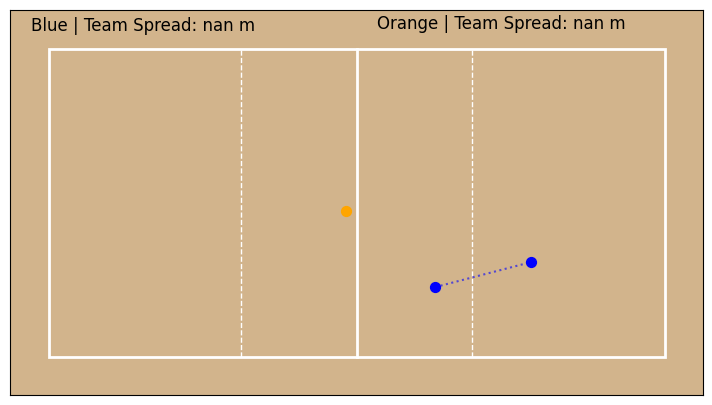

In [ ]:
sport = 'volleyball' #soccer, basketball, volleyball
df_b, df_o, anim = calculate_teamspread(sport)

In [101]:
# Create video on .ipynb
HTML(anim.to_html5_video()) 